In [1]:
%reload_ext autoreload
%autoreload 2

In [36]:
from mlbt.strategies import buy_and_hold, monthly_rebalance, cross_sectional_momentum_topn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from mlbt.yaml_io import read_yaml
from mlbt.load_prices import load_prices

In [11]:
config = read_yaml("../config/run2.yaml")
benchmarks = config.get("benchmarks", [])
stocks = config.get("stocks", [])
start_date = config.get("min_date", None)
end_date = config.get("max_date", None)

bench_px = load_prices(in_dir=Path("../data/equity_data"),
                tickers=benchmarks,
                start=start_date,
                end=end_date)

px = load_prices(in_dir=Path("../data/equity_data"),
                tickers=stocks,
                start=start_date,
                end=end_date)

In [ ]:
# global params
cost_bps = 10.0

In [21]:
# benchmarks
sp500 = buy_and_hold(bench_px.loc[:, [benchmarks[0]]], cost_bps=cost_bps)
msci_world = buy_and_hold(bench_px.loc[:, [benchmarks[1]]], cost_bps=cost_bps)
ew_bh = buy_and_hold(px, cost_bps=cost_bps)
ew_mr = monthly_rebalance(px, cost_bps=cost_bps)

In [28]:
# strategies
mom = cross_sectional_momentum_topn(
    px=px,
    top_n=10,
    cost_bps=cost_bps,
    lookback_months=12,
    skip_months=1
)

In [35]:
# aligning benchmark to stratgies
T0, Te = mom.start_date, mom.end_date

sp500_aligned = sp500.slice(T0, Te).rebase()
msci_world_aligned = msci_world.slice(T0, Te).rebase()
ew_bh_aligned = ew_bh.slice(T0, Te).rebase()
ew_mr_aligned = ew_mr.slice(T0, Te).rebase()

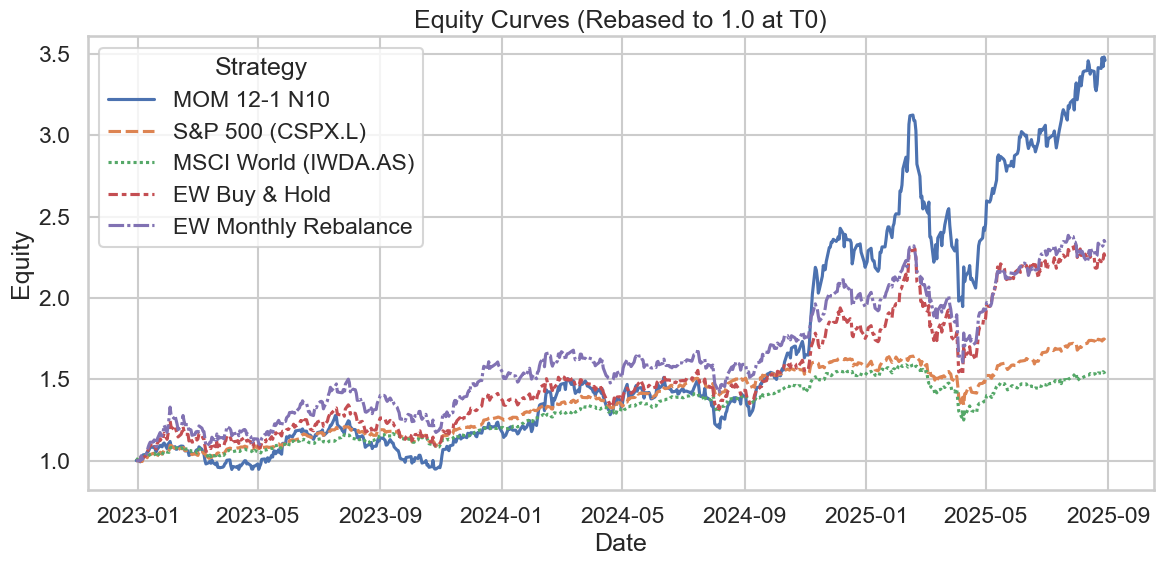

In [38]:
df = pd.concat(
    {
        "MOM 12-1 N10": mom.rebase().equity,
        "S&P 500 (CSPX.L)": sp500_aligned.equity,
        "MSCI World (IWDA.AS)": msci_world_aligned.equity,
        "EW Buy & Hold": ew_bh_aligned.equity,
        "EW Monthly Rebalance": ew_mr_aligned.equity,
    },
    axis=1,
).dropna(how="all")

# Plot
sns.set_theme(context="talk", style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df)
plt.title("Equity Curves (Rebased to 1.0 at T0)")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend(title="Strategy", loc="best")
plt.tight_layout()
plt.show()